# Kaggle Playground 

### Problem Statement / Real World Implementations

### 1. Importing Libraries

In [1]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import warnings

# Visualization Libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn for Preprocessing and Modeling
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Tuning
import optuna

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 2. Loading Dataset

In [2]:
# Define file paths
TRAIN_PATH = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_PATH = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

# Load the datasets into pandas DataFrames
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
submission_df = pd.read_csv(SUBMISSION_PATH)

### 3. Normalization of data

In [3]:
# Save the test IDs now, before we drop the 'id' column
test_ids = test_df['id']

# Drop 'id' from both, as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [4]:
# --- 3. Feature Engineering (Financial Ratios) ---
def create_financial_features(df):
    df['monthly_income'] = df['annual_income'] / 12
    df['total_monthly_debt'] = df['debt_to_income_ratio'] * df['monthly_income']
    df['available_income'] = df['monthly_income'] - df['total_monthly_debt']
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    df['loan_to_available_income'] = df['loan_amount'] / df['available_income']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    cols_to_drop = ['annual_income', 'debt_to_income_ratio']
    df = df.drop(columns=cols_to_drop)
    return df

print("Creating financial features for train_df...")
train_df = create_financial_features(train_df)
print("Creating financial features for test_df...")
test_df = create_financial_features(test_df)


# --- 4. Smart Encoding & Processing ---
def process_and_encode_features(df_train, df_test):
    train_target = df_train['loan_paid_back']
    df_train = df_train.drop('loan_paid_back', axis=1)
    
    df_train['source'] = 'train'
    df_test['source'] = 'test'
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Bin Credit Score
    score_bins = [300, 579, 669, 739, 799, 850]
    score_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    combined_df['credit_score_bin'] = pd.cut(combined_df['credit_score'], 
                                             bins=score_bins, 
                                             labels=score_labels, 
                                             include_lowest=True)
    
    # Logical Ordinal Mapping
    education_map = {'Other': 0, 'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'PhD': 4}
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrades = ['1', '2', '3', '4', '5']
    grade_map = {g + s: i for i, (g, s) in enumerate((g, s) for g in grades for s in subgrades)}
    combined_df['education_level_ordinal'] = combined_df['education_level'].map(education_map)
    combined_df['grade_subgrade_ordinal'] = combined_df['grade_subgrade'].map(grade_map)

    # Ordinal Encode Remaining Categoricals
    categorical_cols = ['gender', 'marital_status', 'employment_status', 'loan_purpose', 'credit_score_bin']
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    combined_df['credit_score_bin'] = combined_df['credit_score_bin'].astype(str)
    combined_df[categorical_cols] = encoder.fit_transform(combined_df[categorical_cols])

    # Handle NaNs (Only for education, let trees handle the rest)
    if combined_df['education_level_ordinal'].isnull().any():
        mode_val = combined_df['education_level_ordinal'].mode()[0]
        combined_df['education_level_ordinal'] = combined_df['education_level_ordinal'].fillna(mode_val)
            
    # Drop old columns and split back
    cols_to_drop = ['credit_score', 'education_level', 'grade_subgrade']
    combined_df = combined_df.drop(columns=cols_to_drop)
    
    train_processed = combined_df[combined_df['source'] == 'train'].drop('source', axis=1)
    test_processed = combined_df[combined_df['source'] == 'test'].drop('source', axis=1)
    
    train_processed['loan_paid_back'] = train_target
    return train_processed, test_processed

print("Processing and encoding all features (letting trees handle NaNs)...")
train_processed, test_processed = process_and_encode_features(train_df, test_df)
print("Processing complete.")

Creating financial features for train_df...
Creating financial features for test_df...
Processing and encoding all features (letting trees handle NaNs)...
Processing complete.


### Train test split

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
import numpy as np

# --- 5. Train-Test Split (for Validation) ---
X = train_processed.drop("loan_paid_back", axis=1)
y = train_processed["loan_paid_back"]
X = X.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. --- REMOVED SCALING --- ---
# Tree models (XGB/LGBM) do not require feature scaling.
# We will feed the unscaled data directly to the models.
print("Skipping scaling, tree models will handle unscaled data and NaNs.")
X_train_scaled = X_train
X_test_scaled = X_test

Skipping scaling, tree models will handle unscaled data and NaNs.


In [6]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ✅ Enable GPU for both XGBoost and LightGBM

# --- 7. Hyperparameter Tuning (Optuna) ---
# --- Hyperparameter tuning for XGBRegressor ---
def objective_xgb(trial):
    param = {
        'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'gpu_id': 0,
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 42
    }
    model = XGBRegressor(**param, verbosity=0)
    model.fit(X_train_scaled, y_train) # Uses unscaled data
    y_pred = model.predict(X_test_scaled) # Uses unscaled data
    mse = mean_squared_error(y_test, y_pred)
    return mse

# --- Hyperparameter tuning for LGBMRegressor ---
def objective_lgbm(trial):
    param = {
        'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0,
        'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'mse',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'random_state': 42, 'verbosity': -1
    }
    model = LGBMRegressor(**param)
    model.fit(X_train_scaled, y_train) # Uses unscaled data
    y_pred = model.predict(X_test_scaled) # Uses unscaled data
    mse = mean_squared_error(y_test, y_pred)
    return mse

# --- Run GPU-accelerated Optuna optimization ---
print("🚀 Tuning XGBRegressor (GPU)...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=150, timeout=7200)
best_params_xgb = study_xgb.best_params
print(f"✅ Best XGBRegressor parameters: {best_params_xgb}")

print("\n🚀 Tuning LGBMRegressor (GPU)...")
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150, timeout=7200)
best_params_lgbm = study_lgbm.best_params
print(f"✅ Best LGBMRegressor parameters: {best_params_lgbm}")

# --- 8. Initialize and Evaluate Tuned Models ---
xgb_model = XGBRegressor(**best_params_xgb, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)
lgbm_model = LGBMRegressor(**best_params_lgbm, device='gpu')
models = [("XGBRegressor (GPU)", xgb_model), ("LGBMRegressor (GPU)", lgbm_model)]

print("\n⚡ Evaluating Tuned Models on GPU...\n")
mse_scores = []
model_names = []
for name, model in models:
    model.fit(X_train_scaled, y_train) # Uses unscaled data
    y_pred = model.predict(X_test_scaled) # Uses unscaled data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    model_names.append(name)
    print(f"{name:<30} | MSE: {mse:.5f} | MAE: {mae:.5f} | R²: {r2:.5f}")

[I 2025-11-03 14:01:19,876] A new study created in memory with name: no-name-48dc906d-e818-4acb-bbbe-5e70ce0d0232


🚀 Tuning XGBRegressor (GPU)...


[I 2025-11-03 14:01:23,548] Trial 0 finished with value: 0.07875003870408565 and parameters: {'lambda': 0.003297652232646508, 'alpha': 2.601489400516726, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008713428997546704, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 284}. Best is trial 0 with value: 0.07875003870408565.
[I 2025-11-03 14:01:28,184] Trial 1 finished with value: 0.07766447193398597 and parameters: {'lambda': 0.0071102438462940926, 'alpha': 5.241108941333859, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.011294072507615549, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 104}. Best is trial 1 with value: 0.07766447193398597.
[I 2025-11-03 14:01:35,952] Trial 2 finished with value: 0.07622454768277283 and parameters: {'lambda': 0.035913647456981515, 'alpha': 0.0023817838099940243, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.04867465810687974, 'n_estimators': 700, 'max_depth': 10, 'min_child_weight': 211}.

✅ Best XGBRegressor parameters: {'lambda': 0.03793493921768352, 'alpha': 0.04748837204206898, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02245363654812717, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 56}

🚀 Tuning LGBMRegressor (GPU)...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-11-03 14:17:41,466] Trial 0 finished with value: 0.07621798541905134 and parameters: {'lambda_l1': 0.0031852790371024392, 'lambda_l2': 0.0006735934991910609, 'num_leaves': 230, 'feature_fraction': 0.5084478298271974, 'bagging_fraction': 0.6275212971248738, 'bagging_freq': 6, 'min_child_samples': 80

✅ Best LGBMRegressor parameters: {'lambda_l1': 0.00018313921988314782, 'lambda_l2': 0.030161660855068575, 'num_leaves': 180, 'feature_fraction': 0.6952700125088407, 'bagging_fraction': 0.732692814506615, 'bagging_freq': 7, 'min_child_samples': 90, 'learning_rate': 0.014726348239944098, 'n_estimators': 800, 'max_depth': 9}

⚡ Evaluating Tuned Models on GPU...

XGBRegressor (GPU)             | MSE: 0.07543 | MAE: 0.15229 | R²: 0.53207
LGBMRegressor (GPU)            | MSE: 0.07540 | MAE: 0.15307 | R²: 0.53224


In [7]:
best_idx = np.argmin(mse_scores)
best_model_name = model_names[best_idx]
best_model = models[best_idx][1] # This line is correct, it selects the model object
print(f"\n✅ Best Model Based on MSE: {best_model_name}")


✅ Best Model Based on MSE: LGBMRegressor (GPU)


In [8]:
# --- 9. Final Training on Full Data ---
print("\n🚀 Retraining the best model on full training data...")
X_full = train_processed.drop(columns=['loan_paid_back'], errors='ignore')
y_full = train_processed['loan_paid_back']
X_full = X_full.select_dtypes(include=[np.number])

# --- REMOVED SCALING --- ---
# Retrain best model on the full UN-SCALED dataset
X_full_scaled = X_full # Keep variable name for consistency
best_model.fit(X_full_scaled, y_full)
print(f"✅ Model retrained successfully: {best_model_name} ({best_model.__class__.__name__})\n")


🚀 Retraining the best model on full training data...
✅ Model retrained successfully: LGBMRegressor (GPU) (LGBMRegressor)



### Selecting best model and Generating Submission

In [9]:
# --- 10. Generate Submission ---
print("🔮 Generating predictions using the best model...")

X_submission = test_processed.select_dtypes(include=[np.number])
X_submission = X_submission[X_full.columns] # Align column order

# --- REMOVED SCALING --- ---
# Predict on the UN-SCALED test data
X_submission_scaled = X_submission # Keep variable name for consistency
submission_preds_raw = best_model.predict(X_submission_scaled)
# --- END OF CHANGE ---

# Clip the predictions
submission_preds = np.clip(submission_preds_raw, 0, 1)

# --- Create Submission File ---
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': submission_preds
})
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' generated successfully!")
display(submission.head())

🔮 Generating predictions using the best model...

✅ Submission file 'submission.csv' generated successfully!


,id,loan_paid_back
0,593994,0.952849
1,593995,0.956750
2,593996,0.524125
3,593997,0.959660
4,593998,0.991163


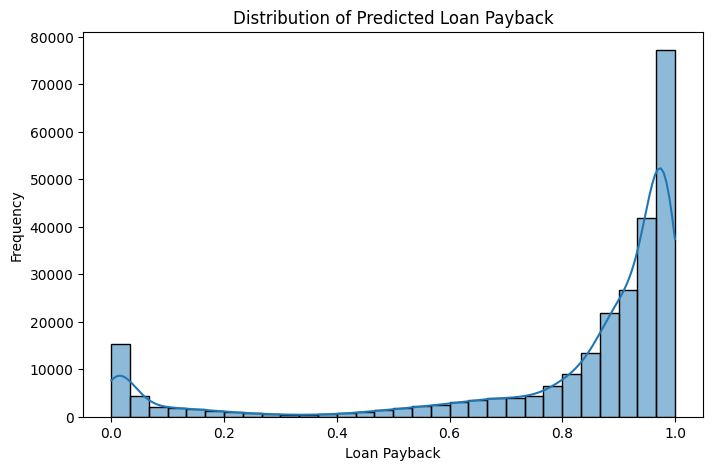

In [10]:
# --- 11. Final Plot ---
plt.figure(figsize=(8, 5))
sns.histplot(submission['loan_paid_back'], bins=30, kde=True)
plt.title('Distribution of Predicted Loan Payback')
plt.xlabel('Loan Payback')
plt.ylabel('Frequency')
plt.show()